### Build a QSAR model in 8 lines of Python
When I encounter a new dataset.  I often want to construct a simple model to get a quick idea of how easy or hard it will be to model the data.  Over the years, I've put together several scripts to do this.  Recently, I've come across a few Python packages that make this whole task a lot easier.  One thing I like about the workflow below is that it's flexible.  I can change the input format, the descriptors, or the machine learning model by changing one line of code.  This script doesn't take the place of rigorous validation but it provides a quick place to start.  

Ok, I admit that there are more than 8 lines of code here.  I added some more to illustrate what we're doing.  However, there are only **8 lines** here that are critical.

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !uv pip install --system rdkit pandas datamol molfeat numpy scikit-learn yellowbrick wget

Using Python 3.12.11 environment at: /usr
Resolved 100 packages in 1.78s
Prepared 15 packages in 2.07s
Uninstalled 2 packages in 7ms
Installed 15 packages in 140ms
 + aiobotocore==2.24.2
 + aioitertools==0.12.0
 + botocore==1.40.18
 + datamol==0.12.5
 - fsspec==2025.3.0
 + fsspec==2025.9.0
 - gcsfs==2025.3.0
 + gcsfs==2025.9.0
 + jmespath==1.0.1
 + loguru==0.7.3
 + molfeat==0.11.0
 + mordredcommunity==2.0.6
 + pmapper==1.1.3
 + rdkit==2025.3.6
 + s3fs==2025.9.0
 + selfies==2.2.0
 + wget==3.2


In [3]:
import pandas as pd
import datamol as dm
from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from yellowbrick.regressor import prediction_error, residuals_plot
import wget

# **0.** Get an input file.  
To start we need a csv file with Chemical structures as SMILES and some property or actvity file.  The file should have a column named **SMILES** and an activity column whose name we will specify below.  If you're running in Google Colab, you'll need to upload the file from your local machine you can do this by first clicking on the **Files** icon on the left, then clicking on the "Upload to session storage" icon in the menu that opens up.  After that, you should see the file in the file explorer on the left.

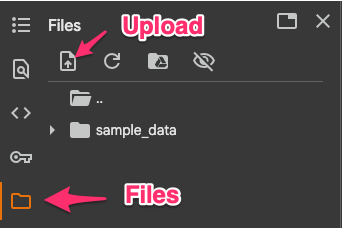

The code below will download a demo file called "carbonic.csv" from GitHub.  If you don't have your own csv file, you can use this one to try out the code below.

In [4]:
wget.download("https://raw.githubusercontent.com/PatWalters/datafiles/refs/heads/main/carbonic.csv")

'carbonic.csv'

## **1.** Read the data into a [Pandas](https://pandas.pydata.org/) dataframe.    
In the next cell we read the data from a csv file and put it into a Pandas dataframe, a structure that holds a datatable in memory for a Python script to use. If you want to use your own csv file, upload it as described above, then change
```python
filename = "carbonic.csv"
```
to
```python
filename = "myfile.csv"
```
where `myfile.csv` is the name of the file you uploaded.  The code below uses the last column in the dataframe as the the acivity column.  If this isn't the case, change the code below to assign the correct column.

In [9]:
filename = "carbonic.csv"
df = pd.read_csv(filename)
activity_col = df.columns[-1]
print(f"The activity column is proably {activity_col}")
df.head()

The activity column is proably pIC50


,SMILES,Name,pIC50
0,CC(C)CN(C)Cc1cc(ccc1O)C(=O)c2cc(sc2)S(=O)(=O)N,CHEMBL544127,8.05
1,COc1ccc(cc1)C(=O)c2cc(oc2)S(=O)(=O)N,CHEMBL340519,8.70
2,CN(C)Cc1cc(ccc1O)C(=O)c2cc(sc2)S(=O)(=O)N,CHEMBL541089,8.19
3,c1cc(ccc1CN2CCOCC2)S(=O)(=O)c3cc(sc3)S(=O)(=O)N,CHEMBL555153,8.12
4,CC(C)CN(C)Cc1cc(ccc1O)S(=O)(=O)c2cc(sc2)S(=O)(...,CHEMBL539817,8.30


## **2.** Instantiate a Fingerprint calculator from the awesome [molfeat](https://m2d2.io/blog/posts/introducing-molfeat-a-hub-of-molecular-featurizers/) package. This package has several descriptor types available.
```python
>>> from molfeat.calc import FP_FUNCS
>>> FP_FUNCS.keys()
dict_keys(['maccs', 'avalon', 'ecfp', 'fcfp', 'topological', 'atompair', 'rdkit', 'pattern', 'layered', 'map4', 'secfp', 'erg', 'estate', 'avalon-count', 'rdkit-count', 'ecfp-count', 'fcfp-count', 'topological-count', 'atompair-count'])
```

In [20]:
calc = FPCalculator("ecfp")

## **3.** Instantiate a molecule transfomer from molfeat.    
This object takes a list of SMILES as input and returns descriptors.  It's very flexible and can run in parallel.  [Check it out!](https://molfeat-docs.datamol.io/stable/tutorials/types_of_featurizers.html)

In [21]:
trans = MoleculeTransformer(calc)

## **4-5.** Calculate the fingerprints.    
Note the use of the function from [datamol](https://datamol.io) that silences logging messages from the RDKit.  This is more polite version of my rd_shut_the_hell_up function in [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils).

In [22]:
%%time
with dm.without_rdkit_log():
    df['fp'] = trans.transform(df.SMILES.values)

CPU times: user 171 ms, sys: 1.11 ms, total: 172 ms
Wall time: 173 ms


## **6.** Split the data into training and test sets.  
I like to do this with dataframes.  That way I don't have to remember the order in which `train_X, test_X, train_y, and test_y` are returned by [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [23]:
train, test = train_test_split(df)

## **7.** Instantiate an sklearn style regressor.  
In this case I used [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html), which is the scikit-learn implementation of [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html).  You can easily plug in any scikit-learn compatible regressor like [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) or [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html).
```python
from lightgbm import LGBMRegressor
model = LGBMRegressor()
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
from xgboost import XGBRegressor
model = XGBRegressor()
```

In [29]:
model = HistGradientBoostingRegressor()

## **8.** Use [YellowBrick](https://www.scikit-yb.org/en/latest/) to build a model and visualize its performance.
The **Loss** reported in the plot below is the [$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) for the model.

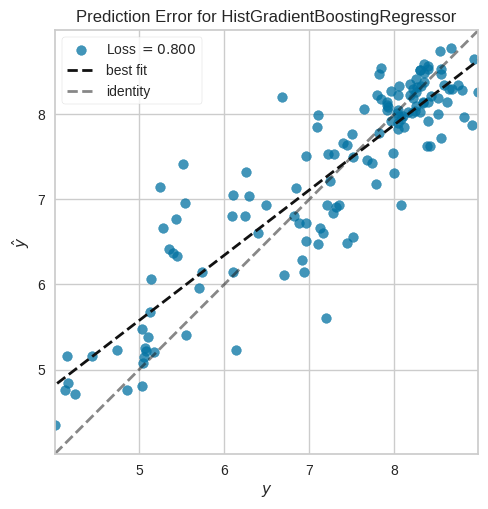

CPU times: user 5.4 s, sys: 1.47 s, total: 6.87 s
Wall time: 6.93 s


In [30]:
%%time
visualizer = prediction_error(model,np.stack(train.fp),train[activity_col],np.stack(test.fp),test[activity_col])

### Bonus
Plot the residuals for the training and test sets

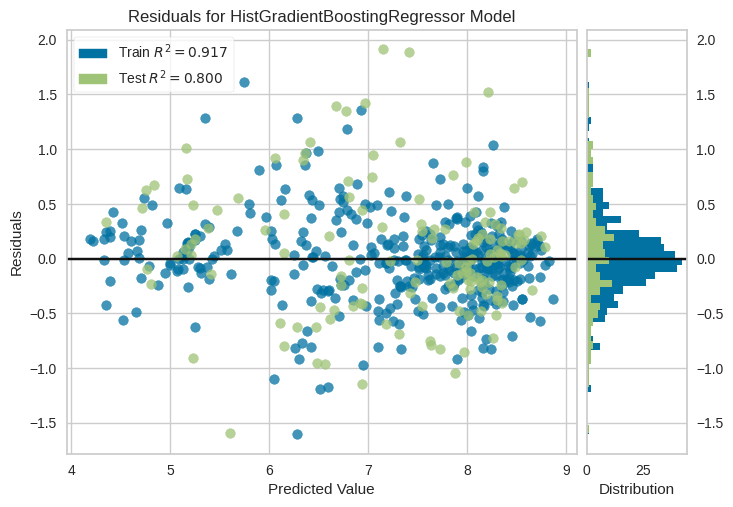

In [26]:
viz = residuals_plot(model,np.stack(train.fp), train[activity_col], np.stack(test.fp), test[activity_col], is_fitted=True)